#### Handle the imports

In [1]:
from nipype import Node, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces import freesurfer, fsl, mrtrix
from nipype.interfaces.dcm2nii import Dcm2nii
from nipype.interfaces.io import DataFinder

In [2]:
from multiprocessing import cpu_count
import numpy as np
import logging

#### Define a function for the preprocessing workflow

In [ ]:
# def preproc_sub(subject_folder, subject_id):

#### Start the logging

In [3]:
logger = logging.getLogger('interface')
logger.setLevel(logging.DEBUG)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

#### Define the later function variables in hard-code for debuging

In [4]:
subject_folder = '/Users/srothmei/Desktop/charite/toronto/'
subject_id = 'FR_20120903'

### Define Inputnode and Outputnode

In [5]:
inputNode = Node(IdentityInterface(fields=['subject_id', 'subject_folder']), mandatory_inputs=True, name='input')
inputNode.inputs.subject_id = subject_id
inputNode.inputs.subject_folder = subject_folder

# TODO: Define Output node

## Set parameters and build variables

In [45]:
reconallFolderName = 'recon_all' # Define what the output folder of recon-all should be named

def pathBuilder(subject_folder, subject_id):
    subPath = subject_folder + '/' + subject_id # Build full path to subject folder
    
    # RawData Structure
    rawdataFolder = subPath + '/RAWDATA' # Define the path to the folder holding the rawdata dicom-files
    T1RawFolder = rawdataFolder + '/MPRAGE/' # The T1 rawdata folder
    dwiRawFolder = rawdataFolder + '/DTI' # The dwMRI rawdata folder
    fmriRawFolder = rawdataFolder + '/BOLD-EPI/' # The fMRI rawdata folder
    
    return subPath, rawdataFolder, T1RawFolder, dwiRawFolder, fmriRawFolder

pathBuildingNode = Node(Function(input_names = ['subject_folder', 'subject_id'],
                                output_names = ['subPath', 'rawdataFolder', 'T1RawFolder',
                                                'dwiRawFolder', 'fmriRawFolder'],
                                function = pathBuilder),
                        name='pathBuilder')

In [7]:
logger.info('Start the preprocessing for subject ' + subject_id)

2015-10-31 18:45:48,877 - INFO - Start the preprocessing for subject FR_20120903
INFO:interface:Start the preprocessing for subject FR_20120903


### Structural Data (T1) preprocessing

In [41]:
logger.info('Start recon_all')

# Setup a datafinder to find the paths to the specific DICOM files
t1FinderNode = Node(DataFinder(), name = 't1Finder')
t1FinderNode.inputs.match_regex = '.*\.dcm'
#df = DataFinder(root_paths = T1RawFolder, match_regex = '.*\.dcm')
#firstFile = df.run().outputs.out_paths[0]

# Set recon-all parameters
reconallNode = Node(freesurfer.preprocess.ReconAll(), name = 'reconall')
#reconallNode.inputs.T1_files = firstFile
#reconallNode.inputs.subjects_dir = subPath
reconallNode.inputs.subject_id = reconallFolderName
reconallNode.inputs.directive = 'all'
reconallNode.inputs.openmp = cpu_count()

# Convert the T1 mgz image to nifti format for later usage
mriConverter = Node(freesurfer.preprocess.MRIConvert(), name = 'convertAparcAseg')
#convertT1.inputs.out_file = subPath + reconallFolderName + '/mri/aparc+aseg.nii.gz'
mriConverter.inputs.out_type = 'niigz'
mriConverter.inputs.out_orientation = 'RAS'

2015-10-31 19:11:13,239 - INFO - Start recon_all
INFO:interface:Start recon_all


### Diffusion Data (dwMRI) preprocessing

In [54]:
logger.info('Start dt_recon')

# First extract the diffusion vectors and the pulse intensity (bvec and bval)
# Use dcm2nii for this task
dwiFinderNode = t1FinderNode.clone('dwiFinder')

dcm2niiNode = Node(Dcm2nii(), name = 'dcm2niiAndBvecs')
dcm2niiNode.inputs.gzip_output = True

# Now create the node for dt_recon
dtReconNode = Node(freesurfer.preprocess., name = 'dt_recon')


2015-10-31 19:15:27,141 - INFO - Start dt_recon
INFO:interface:Start dt_recon


### Connect the Nodes

In [67]:
wf = Workflow(name = 'preprocSub')

# Input strings to pathbuilder
wf.connect([(inputNode, pathBuildingNode, [('subject_id', 'subject_id'),
                                          ('subject_folder', 'subject_folder')])])
# T1-Rawdata-path into dataFinder to find T1 DICOMs
wf.connect(pathBuildingNode, 'T1RawFolder', dataFinderNode, 'root_paths')
# T1 DICOM-paths into recon_all
wf.connect(dataFinderNode, 'out_paths', reconallNode, 'T1_files')
# aparc+aseg into mriConverter
wf.connect(reconallNode, 'aparc_aseg', mriConverter, 'in_file')

# Now insert the dwMRI RAWDATA path into the pathfinder
wf.connect(pathBuildingNode, 'dwiRawFolder', dwiFinderNode, 'root_paths')
# Take the findings and insert them into dcm2nii
wf.connect([(dwiFinderNode, dcm2niiNode, [('out_paths', 'source_names')]),
             (pathBuildingNode, dcm2niiNode, [('dwiRawFolder', 'output_dir')])])
# Connect dcm2nii with dt_recon
wf.connect()

In [69]:
Dcm2nii.output_spec()


bvals = <undefined>
bvecs = <undefined>
converted_files = <undefined>
reoriented_and_cropped_files = <undefined>
reoriented_files = <undefined>

### Plot the workflow graph

DEBUG:interface:{'DISPLAY': ':1'}
INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot to png format


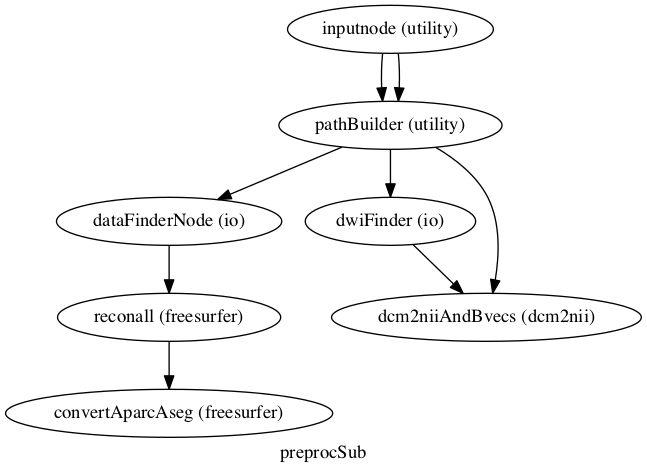

In [68]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="workflow_graph.dot.png")
#from matplotlib import image as Image
#print(wf.write_graph.__doc__)